# MMS SITL Ground Loop: Model Performance Measures
This notebook reproduces several of the figures associated with model performance in Argall, Small, et al. 2020.

**CONTENTS**
* [Front Matter](#front_matter)
* [Configurable Parameters](#inputs)
* [Metric Calculations](#metric)
* [Burst Selections](#selections)
* [Histogram Overlap](#histogram)
* [Venn Diagram](#venn_diagram)
* [Confusion Matrix, Precision, Recall, F1 Score](#f1_score)
* [Confusion Matrix Plot](#confusion_matrix)

<a id='front_matter'></a>
## Front matter

In [1]:
import pathlib
import datetime as dt
import pymms
from pymms.sdc import selections as sel
from pymms.sdc import mrmms_sdc_api as api
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

<a id='inputs'></a>
## Configurable Parameters
The figure plots data from SROI 1 only between 19 Oct. 2019, which is when the GLS was fully implemented, and 25 Mar. 2020, a few days before the paper was submitted. To reproduce the plots in the supplemental material, set `sroi=None` and `sroi=3`.

In [2]:
sroi = 1
outdir = pymms.config['gls_root'] + '/gls_paper' # Set to None to suppress output
fig_type = 'svg' # eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
start_date = dt.datetime(2019, 10, 19)
end_date = dt.datetime(2020, 3, 25, 18, 44, 46)

# Filter selections to be within a particular SROI
do_sroi=0
if sroi in (1, 2, 3):
    do_sroi=True

# Location to save the figure
if outdir is not None:
    outdir = pathlib.Path(outdir).expanduser()
    if not outdir.exists():
        outdir.mkdir(parents=True)

<a id='metric'></a>
## Metric Calculations
A function to calculate and histogram the overlap between selections.

In [3]:
def plot_metric(ref_data, test_data, fig, labels, location,
                nbins=10):
    '''
    Visualize the overlap between segments.

    Parameters
    ----------
    ref_data : list of `BurstSegment`s
        Reference burst segments
    test_data : list of `BurstSegment`s
        Test burst segments. Determine which test segments
        overlap with the reference segments and by how much
    labels : tuple of str
        Labels for the reference and test segments
    location : tuple
        Location of the figure (row, col, nrows, ncols)
    nbins : int
        Number of histogram bins to create

    Returns:
    --------
    ax : `matplotlib.pyplot.Axes`
        Axes in which data is displayed
    ref_test_data : list of `BurstSegment`s
        Reference data that falls within the [start, stop] times
        of the test data.
    '''

    # Determine by how much the test data overlaps with
    # the reference data.
    ref_test = []
    ref_test_data = []
    ref_test = [selection_overlap(segment, test_data)
                for segment in ref_data]

    # Overlap statistics
    #   - Number of segments selected
    #   - Percentage of segments selected
    #   - Percent overlap from each segment
    ref_test_selected = sum(selection['n_selections'] > 0
                            for selection in ref_test)
    ref_test_pct_selected = ref_test_selected / len(ref_test) * 100.0
    ref_test_pct_overlap = [selection['pct_overlap'] for selection in ref_test]

    # Calculate the plot index from the (row,col) subplot location
    plot_idx = lambda rowcol, ncols : (rowcol[0]-1)*ncols + rowcol[1]

    # Create a figure
    ax = fig.add_subplot(location[2], location[3],
                         plot_idx(location[0:2], location[3]))
    hh = ax.hist(ref_test_pct_overlap, bins=nbins, range=(0, 100))
    #ax.set_xlabel('% Overlap Between {0} and {1} Segments'.format(*labels))
    if location[0] == location[2]:
        ax.set_xlabel('% Overlap per Segment')
    if location[1] == 1:
        ax.set_ylabel('Occurrence')
    ax.text(0.5, 0.98, '{0:4.1f}% of {1:d}'
              .format(ref_test_pct_selected, len(ref_test)),
              verticalalignment='top', horizontalalignment='center',
              transform=ax.transAxes)
    ax.set_title('{0} Segments\nSelected by {1}'.format(*labels))

    return ax, ref_test

Determine how much overlap one burst segment of a given class has with another class of burst segments.

In [4]:
def selection_overlap(ref, tests):
    '''
    Gather overlap statistics.
    
    Parameters
    ----------
    ref : `selections.BurstSegment`
        The reference burst segment.
    tests : list of `selections.BurstSegment`
        The burst segements against which the reference segment is compared.
    
    Returns
    -------
    out : dict
        Data regarding how much the reference segment overlaps with the
        test segments.
    '''
    out = {'dt': ref.tstop - ref.tstart,
           'dt_next': dt.timedelta(days=7000),
           'n_selections': 0,
           't_overlap': dt.timedelta(seconds=0.0),
           't_overselect': dt.timedelta(seconds=0.0),
           'pct_overlap': 0.0,
           'pct_overselect': 0.0
           }

    # Find which selections overlap with the given entry and by how much
    tdelta = dt.timedelta(days=7000)
    for test in tests:

        if ((test.tstart <= ref.tstop) and
            (test.tstop >= ref.tstart)
            ):
            out['n_selections'] += 1
            out['t_overlap'] += (min(test.tstop, ref.tstop)
                                 - max(test.tstart, ref.tstart)
                                 )

        # Time to nearest interval
        out['dt_next'] = min(out['dt_next'], abs(test.tstart - ref.tstart))

    # Overlap and over-selection statistics
    if out['n_selections'] > 0:
        out['t_overselect'] = out['dt'] - out['t_overlap']
        out['pct_overlap'] = out['t_overlap'] / out['dt'] * 100.0
        out['pct_overselect'] = out['t_overselect'] / out['dt'] * 100.0
    else:
        out['t_overselect'] = out['dt']
        out['pct_overselect'] = 100.0

    return out

<a id='selections'></a>
## Burst Selections
Get the SITL, ABS, and GLS burst selections. Filter by SROI and determine which SITL selections were classified as magnetopause crossings.

In [5]:
abs_data = sel.selections('abs', start_date, end_date,
                          latest=True, combine=True, metadata=do_sroi)

gls_data = sel.selections('mp-dl-unh', start_date, end_date,
                          latest=True, combine=True, metadata=do_sroi)

sitl_data = sel.selections('sitl+back', start_date, end_date,
                           latest=True, combine=True, metadata=do_sroi)

# Filter by SROI
if do_sroi:
    abs_data = [s for s in abs_data if s.sroi == sroi]
    sitl_data = [s for s in sitl_data if s.sroi == sroi]
    gls_data = [s for s in gls_data if s.sroi == sroi]

sitl_mp_data = sel.filter_segments(sitl_data, '(MP|Magnetopause|magnetopause)', case_sensitive=True)

GLS Selection Adjustments:
  # files skipped:    267
  # entries skipped:  13
  # entries expanded: 458


Save the selections for reference.

In [6]:
if outdir is not None:
    sroi_str = ''
    if do_sroi:
        sroi_str = '_sroi{0:d}'.format(sroi)
    
    for stype, data in zip(('sitl', 'abs', 'gls'), (sitl_data, abs_data, gls_data)):
        csv_fname = (outdir
                     / '_'.join((stype + '_selections' + sroi_str,
                                 start_date.strftime('%Y%m%d%H%M%S'),
                                 end_date.strftime('%Y%m%d%H%M%S')
                                 )))
        csv_fname = csv_fname.with_suffix('.csv')
        sel.write_csv(csv_fname, data)

<a id='histogram'></a>
## Histogram Overlap
Here, we create the figure. `plot_metric` will determine the overlap between each class of selections, plot a histogram of the results, and annotate the figure with summary statistics.

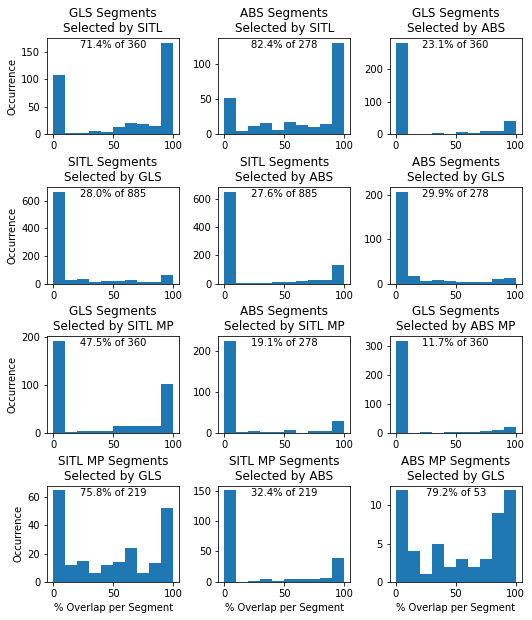

In [7]:
# Create a figure
nbins = 10
nrows = 4
ncols = 3
fig = plt.figure(figsize=(8.5, 10))
fig.subplots_adjust(hspace=0.55, wspace=0.3)

# GLS-SITL Comparison
ax, gls_sitl = plot_metric(gls_data, sitl_data, fig,
                           ('GLS', 'SITL'), (1, 1, nrows, ncols),
                           nbins=nbins)
ax, sitl_gls = plot_metric(sitl_data, gls_data, fig,
                           ('SITL', 'GLS'), (2, 1, nrows, ncols),
                           nbins=nbins)
ax, gls_sitl_mp = plot_metric(gls_data, sitl_mp_data, fig,
                              ('GLS', 'SITL MP'), (3, 1, nrows, ncols),
                              nbins=nbins)
ax, sitl_mp_gls = plot_metric(sitl_mp_data, gls_data, fig,
                              ('SITL MP', 'GLS'), (4, 1, nrows, ncols),
                              nbins=nbins)

# ABS-SITL Comparison
ax, abs_sitl = plot_metric(abs_data, sitl_data, fig,
                           ('ABS', 'SITL'), (1, 2, nrows, ncols),
                           nbins=nbins)
ax, sitl_abs = plot_metric(sitl_data, abs_data, fig,
                           ('SITL', 'ABS'), (2, 2, nrows, ncols),
                           nbins=nbins)
ax, abs_sitl_mp = plot_metric(abs_data, sitl_mp_data, fig,
                              ('ABS', 'SITL MP'), (3, 2, nrows, ncols),
                              nbins=nbins)
ax, sitl_mp_abs = plot_metric(sitl_mp_data, abs_data, fig,
                              ('SITL MP', 'ABS'), (4, 2, nrows, ncols),
                              nbins=nbins)

# GLS-ABS Comparison
abs_mp_data = [abs_data[idx]
               for idx, s in enumerate(abs_sitl_mp)
               if s['n_selections'] > 0]

ax, gls_abs = plot_metric(gls_data, abs_data, fig,
                          ('GLS', 'ABS'), (1, 3, nrows, ncols),
                          nbins=nbins)
ax, abs_gls = plot_metric(abs_data, gls_data, fig,
                          ('ABS', 'GLS'), (2, 3, nrows, ncols),
                          nbins=nbins)
ax, gls_abs_mp = plot_metric(gls_data, abs_mp_data, fig,
                             ('GLS', 'ABS MP'), (3, 3, nrows, ncols),
                             nbins=nbins)
ax, abs_mp_gls = plot_metric(abs_mp_data, gls_data, fig,
                             ('ABS MP', 'GLS'), (4, 3, nrows, ncols),
                             nbins=nbins)

# Save the figure
if outdir is not None:
    sroi_str = ''
    if do_sroi:
        sroi_str = '_sroi{0:d}'.format(sroi)
    filename = (outdir
                / '_'.join(('histogram_metric' + sroi_str,
                            start_date.strftime('%Y%m%d%H%M%S'),
                            end_date.strftime('%Y%m%d%H%M%S')
                            )))
    filename = filename.with_suffix('.'+fig_type)
    plt.savefig(filename)

<a id='venn_diagram'></a>
## Venn Diagram
An alternative way of viewing the overlap between SITL, ABS, and GLS selections is with a Venn diagram.

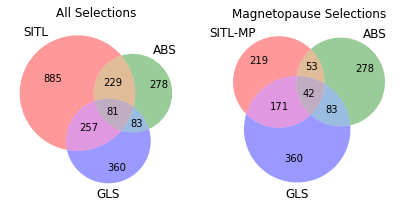

In [8]:
# All segments
#  - ABS segements that overlapped with at least one SITL segment
#  - GLS segements that overlapped with at least one SITL segment
#  - GLS segements that overlapped with at least one ABS segment
#  - GLS segements that overlapped with at least one SITL-ABS segment
sitl_abs_data = [segment
                 for segment in abs_data
                 if sel.selection_overlap(segment, sitl_data)['n_selections'] > 0]
sitl_gls_data = [segment
                 for segment in gls_data
                 if sel.selection_overlap(segment, sitl_data)['n_selections'] > 0]
abs_gls_data = [segment
                for segment in gls_data
                if sel.selection_overlap(segment, abs_data)['n_selections'] > 0]
sitl_abs_gls_data = [segment
                     for segment in gls_data
                     if sel.selection_overlap(segment, sitl_abs_data)['n_selections'] > 0]

# MP Segments
#  - ABS segements that overlapped with at least one SITL MP segment
#  - GLS segements that overlapped with at least one SITL MP segment
#  - GLS segements that overlapped with at least one SITL MP-ABS segment
sitl_mp_abs_data = [segment
                    for segment in abs_data
                    if sel.selection_overlap(segment, sitl_mp_data)['n_selections'] > 0]
sitl_mp_gls_data = [segment
                    for segment in gls_data
                    if sel.selection_overlap(segment, sitl_mp_data)['n_selections'] > 0]
sitl_mp_abs_gls_data = [segment
                        for segment in gls_data
                        if sel.selection_overlap(segment,
                                                 sitl_mp_abs_data
                                                 )['n_selections'] > 0
                        ]

# Numbers for Venn diagram
n_sitl = len(sitl_data)
n_abs = len(abs_data)
n_sitl_abs = len(sitl_abs_data)
n_gls = len(gls_data)
n_sitl_gls = len(sitl_gls_data)
n_abs_gls = len(abs_gls_data)
n_sitl_abs_gls = len(sitl_abs_gls_data)

# Numbers for Venn diagram
n_sitl_mp = len(sitl_mp_data)
n_sitl_mp_abs = len(sitl_mp_abs_data)
n_sitl_mp_gls = len(sitl_mp_gls_data)
n_sitl_mp_abs_gls = len(sitl_mp_abs_gls_data)

# Setup the figure
fig = plt.figure(figsize=(7, 4))

# Venn Diagram: All Selections
ax = fig.add_subplot(1, 2, 1)
venn3(subsets=[n_sitl, n_abs, n_sitl_abs,
               n_gls, n_sitl_gls, n_abs_gls,
               n_sitl_abs_gls
               ],
      set_labels=['SITL', 'ABS', 'GLS'],
      alpha=0.4, ax=ax
      )
plt.title('All Selections')

# Venn Diagram: MP Selections
ax = fig.add_subplot(1, 2, 2)
venn3(subsets=[n_sitl_mp, n_abs, n_sitl_mp_abs,
               n_gls, n_sitl_mp_gls, n_abs_gls,
               n_sitl_mp_abs_gls
               ],
      set_labels=['SITL-MP', 'ABS', 'GLS'],
      alpha=0.4, ax=ax
      )
plt.title('Magnetopause Selections')

# Save the figure
if outdir is not None:
    sroi_str = ''
    if do_sroi:
        sroi_str = '_sroi{0:d}'.format(sroi)
    filename = (outdir
                / '_'.join(('venn_diagram' + sroi_str,
                            start_date.strftime('%Y%m%d%H%M%S'),
                            end_date.strftime('%Y%m%d%H%M%S')
                            )))
    filename = filename.with_suffix('.'+fig_type)
    plt.savefig(filename)

<a id='f1_score'></a>
## Confusion Matrix, Precion, Recall, and F1 Score
Assess the model by creating the confusion matrix and computing the precision, recall, and F1 score. To do this, we need to first determine all possible time stamps for which the STIL can make selections.

In [9]:
def selection_time_stamps(start_time, end_time, sc='mms1', method='mdq'):
    '''
    Find all times available to the SITL for selection. The SITL
    can make a selection whenever an MDQ is defined. MDQs are defined
    in the ABS and SITL selection files as the `'timestamp'` field.
    
    Params
    ------
    start_time, end_time : `datetime.datetime`
        Time interval in which to create time stamps
    sc : str
        Reference spacecraft for SROI boundaries. Used only if
        `method='sroi'`
    method : str
        Method by which to create time stamps. Options are 'sroi'
        and 'mdq'. Time stamps for the former are tied to the begin
        and end times of each SROI and are spacecraft-specific. In
        the latter case, time stamps are taken from MDQ values,
        which are spacecraft independent.
    
    Returns
    -------
    time_stamps : `np.array(dtype='int64')`
        All times at which a SITL could have made a selection.
    '''
    if method == 'sroi':
        # Create a time array for each sroi
        orbit_0 = api.time_to_orbit(start_time, sc=sc)
        orbit_1 = api.time_to_orbit(end_time, sc=sc)
    
        # Loop through the SROIs
        time_stamps = np.empty(0, dtype='int64')
        for orbit in range(orbit_0, orbit_1 + 1):
            sroi = sdc.mission_events('sroi', orbit, orbit, sc=sc)
            for tstart, tend in zip(sroi['tstart'], sroi['tend']):
                # Convert SROI interval to TAI seconds
                tai_start = api.datetime_to_tai(tstart)
                tai_stop = api.datetime_to_tai(tend)
                tai_start = tai_start - (tai_start % t_delta)
                tai_stop = tai_stop - (tai_stop % t_delta)
    
                # Create a pandas dataframe with tai_sroi as the index
                time_stamps = np.append(time_stamps,
                                        np.arange(tai_start,
                                                  tai_stop,
                                                  t_delta)
                                        )

    elif method == 'mdq':
        # This is how I would retrieve all possible
        # times that could be selected by the SITL. I would (1) ignore ROI
        # information provided by SDC, (2) retrieve ABS or SITL sav files,
        # and (3) look for the TIMESTAMPS tag. These timestamps define the
        # start time of every "cycle" (It is called "buffer" if selected by
        # the SITL). So, 10.0 needs to be added to the end time to get the
        # end time of the timestamps. I would repeat these commands for all
        # ABS files. Note that, after the dynamic SITL window system is
        # introduced, a time range in one ABS file can be overlapped with a
        # time range in another ABS file. 
    
        # Get all ABS selection data within the time interval
        abs_data = api.burst_selections('abs', start_time, end_time)
    
        # Multiple duplicate/overlapping ABS files can be submitted per orbit/roi
        # Also, since files only contain start time, some data can be outside
        # the given time interval.
        time_stamps = np.unique(abs_data['timestamps'])
        
        # Trim time stamps to time interval
        tai_tstart = api.datetime_to_tai(start_time)
        tai_tend = api.datetime_to_tai(end_time)
        time_stamps = time_stamps[((time_stamps >= tai_tstart)
                                   & (time_stamps <= tai_tend))
                                   ]

    return time_stamps

Next, we use the SITL selections as the ground truth to compute the model scores for the ABS and GLS.

In [10]:
# Generate all possible time stamps
t = selection_time_stamps(start_date, end_date, method='mdq')

In [11]:
# Time cadence at which the SITL can make selections
t_delta = seconds=10

# Selections are made up of 10-second duration burst buffers. Burst
# buffers begin at multiples of 10-seconds in TAI time. A selection
# of duration 60 seconds contains 6 burst buffers.

# Time stamps for 'sitl+back' are from the begin time of the first
# burst buffer to the begin time of the last burst buffer, so that
# adjacent selections are separated by 10 seconds.

# Time stamps for all other selections are from the begin time of
# the first burst buffer to the end time of the last burst buffer,
# so that adjacent selections are separated by 0 seconds.

# Selections are only possible in the SROI when MMS is in fast
# survey mode. Selections occur on multiples of 10-seconds in TAI
# time. To build up the time stamps, take the begin time of an
# SROI and round down to the nearest 10s TAI time, take the end
# time of the same SROI and round up to the nearest 10s TAI time,
# then fill between at a cadence of 10 seconds.

# Create a pandas DataFrame to make indexing by timestamps simple
npts = len(t)
tai_sroi = pd.Index(t)
df = pd.DataFrame(index=tai_sroi)
df['sitl'] = np.zeros(npts, dtype='bool')
df['sitl_mp'] = np.zeros(npts, dtype='bool')
df['abs'] = np.zeros(npts, dtype='bool')
df['gls'] = np.zeros(npts, dtype='bool')

# Python array slicing is exclusive [start, stop). Time stamps `t` are
# the begin time of each "cycle" that can be selected by the sitl.

# 'sitl' selection begin at the begin time of a cycle and extend to the
# end time of the last cycle. This end time is excluded automatically by
# Python slicing.

# 'abs' and 'gls' selections, however, extend from the begin time of the
# first cycle to the begin time of the last cycle. To ensure that the last
# cycle is included in the results, extend each segment to the end of the
# cycle.
for segment in sitl_data:
    df.loc[segment.taistarttime:segment.taiendtime, 'sitl'] = True
for segment in sitl_mp_data:
    df.loc[segment.taistarttime:segment.taiendtime, 'sitl_mp'] = True
for segment in abs_data:
    df.loc[segment.taistarttime:segment.taiendtime + t_delta, 'abs'] = True
for segment in gls_data:
    df.loc[segment.taistarttime:segment.taiendtime + t_delta, 'gls'] = True

Functions to calculate precision, recall, and F1 scores

In [12]:
def recall(true_positive, false_negative):
    return true_positive / (true_positive + false_negative)
def precision(true_positive, false_positive):
    return true_positive / (true_positive + false_positive)
def f1_score(prec, rec):
    return 2 * prec * rec / (prec + rec)

Claculate model performance metrics

In [13]:
# DataFrame of results
score_df = pd.DataFrame(columns=['true_positive', 'false_positive', 'true_negative', 'false_negative',
                                 'recall', 'precision', 'f1_score'],
                        index=['GLS_ALL', 'GLS_MP', 'ABS'])

# Confusion matrices
score_df['true_positive']['GLS_ALL'] = (df.sitl & df.gls).sum()
score_df['false_positive']['GLS_ALL'] = (~df.sitl & df.gls).sum()
score_df['true_negative']['GLS_ALL'] = (~df.sitl & ~df.gls).sum()
score_df['false_negative']['GLS_ALL'] = (df.sitl & ~df.gls).sum()

score_df['true_positive']['GLS_MP'] = (df.sitl_mp & df.gls).sum()
score_df['false_positive']['GLS_MP'] = (~df.sitl_mp & df.gls).sum()
score_df['true_negative']['GLS_MP'] = (~df.sitl_mp & ~df.gls).sum()
score_df['false_negative']['GLS_MP'] = (df.sitl_mp & ~df.gls).sum()

score_df['true_positive']['ABS'] = (df.sitl & df['abs']).sum()
score_df['false_positive']['ABS'] = (~df.sitl & df['abs']).sum()
score_df['true_negative']['ABS'] = (~df.sitl & ~df['abs']).sum()
score_df['false_negative']['ABS'] = (df.sitl & ~df['abs']).sum()

# Metrics
score_df['precision'] = precision(score_df['true_positive'], score_df['false_positive'])
score_df['recall'] = recall(score_df['true_positive'], score_df['false_negative'])
score_df['f1_score'] = f1_score(score_df['precision'], score_df['recall'])

print(score_df)

        true_positive false_positive true_negative false_negative    recall  \
GLS_ALL          4364           3209       1177378          25414  0.146551   
GLS_MP           3155           4418       1197952           4840  0.394622   
ABS              7129           4086       1176501          22649  0.239405   

        precision  f1_score  
GLS_ALL  0.576258  0.233675  
GLS_MP   0.416612  0.405319  
ABS      0.635667  0.347815  


Write results to CSV file

In [14]:
if outdir is not None:
    sroi_str = ''
    if do_sroi:
        sroi_str = '_sroi{0:d}'.format(sroi)
    filename = (outdir
                / '_'.join(('performance_metrics' + sroi_str,
                            start_date.strftime('%Y%m%d%H%M%S'),
                            end_date.strftime('%Y%m%d%H%M%S')
                            )))
    filename = filename.with_suffix('.csv')
    
    # Write
    score_df.to_csv(filename)

<a id='confusion_matrix'></a>
## Plot Confusion Matrix
This function was adapted from [Kaggle](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix).

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          ax=ax,
                          figsize=(8,6),
                          cmap=None,
                          log=False,
                          normalize=True,
                          title='Confusion matrix'):
    """
    Given a confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    
    ax:           Axes in which to draw the confusion matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    
    log:          If True, the colorbar displays the log of the matix
                  If False, the colorbar is scaled linearly

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
    if log:
        img = ax.imshow(np.log10(cm), interpolation='nearest', cmap=cmap)
        cb_title = '$\mathrm{Log_{10}(N)}$'
    else:
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        cb_title = 'N'
    ax.set_title(title)
    cbar = plt.colorbar(img, ax=ax, shrink=0.6)
    cbar.ax.set_ylabel(cb_title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(target_names, rotation=0)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(target_names, rotation=90, verticalalignment='center')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cm.shape == (2,2):
        bb = [['TP', 'FN'], ['FP', 'TN']]
    else:
        bb = [['', ''], ['', '']]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{0:0.4f}\n{1}".format(cm[i, j], bb[i][j]),
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            ax.text(j, i, "{0:,}\n{1}".format(cm[i, j], bb[i][j]),
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.subplots_adjust(wspace=0.5)
    return ax

Make the plots

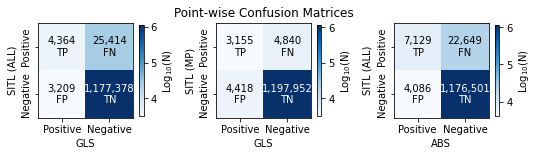

In [16]:
cm_gls_all = np.array([[score_df['true_positive']['GLS_ALL'], score_df['false_negative']['GLS_ALL']],
                       [score_df['false_positive']['GLS_ALL'], score_df['true_negative']['GLS_ALL']]])
cm_gls_mp = np.array([[score_df['true_positive']['GLS_MP'], score_df['false_negative']['GLS_MP']],
                      [score_df['false_positive']['GLS_MP'], score_df['true_negative']['GLS_MP']]])
cm_abs = np.array([[score_df['true_positive']['ABS'], score_df['false_negative']['ABS']],
                   [score_df['false_positive']['ABS'], score_df['true_negative']['ABS']]])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8.5,2.8))

plot_confusion_matrix(cm_gls_all, ax=axes[0], log=True, normalize=False, target_names=['Positive', 'Negative'])
axes[0].set_title('')
axes[0].set_xlabel('GLS')
axes[0].set_ylabel('SITL (ALL)')

plot_confusion_matrix(cm_gls_mp, ax=axes[1], log=True, normalize=False, target_names=['Positive', 'Negative'])
axes[1].set_title('Point-wise Confusion Matrices')
axes[1].set_xlabel('GLS')
axes[1].set_ylabel('SITL (MP)')

plot_confusion_matrix(cm_abs, ax=axes[2], log=True, normalize=False, target_names=['Positive', 'Negative'])
axes[2].set_title('')
axes[2].set_xlabel('ABS')
axes[2].set_ylabel('SITL (ALL)')

# Save the figure
if outdir is not None:
    sroi_str = ''
    if do_sroi:
        sroi_str = '_sroi{0:d}'.format(sroi)
    filename = (outdir
                / '_'.join(('confusion_matrices' + sroi_str,
                            start_date.strftime('%Y%m%d%H%M%S'),
                            end_date.strftime('%Y%m%d%H%M%S')
                            )))
    filename = filename.with_suffix('.'+fig_type)
    plt.savefig(filename)